In [15]:
#!pip install pyrasterframes
#!pip install findspark
#https://rasterframes.io/getting-started.html
#import findspark
#findspark.init()

In [3]:
!export SPARK_HOME="/usr/local/Cellar/apache-spark/2.4.4/libexec/"

In [4]:
from pyrasterframes import rf_ipython
from pyrasterframes.utils import create_rf_spark_session
from pyspark.sql.functions import lit 
from pyrasterframes.rasterfunctions import *

# Use the provided convenience function to create a basic local SparkContext
spark = create_rf_spark_session()

In [5]:
import pyrasterframes
from pyrasterframes.utils import create_rf_spark_session
spark = create_rf_spark_session()

In [6]:
import os
from importlib.util import find_spec
from pyspark.sql import SparkSession
import pyrasterframes

jar_path = os.path.join(os.path.dirname(find_spec("pyrasterframes").origin), 'jars')
pyJar = ','.join([f.path for f in os.scandir(jar_path) if f.name[-3:] == 'jar'])

print (pyJar)

spark = (SparkSession.builder
            .master("local[*]")
            .appName("RasterFrames")
            .config("spark.jars", pyJar)
            .config('spark.driver.extraClassPath', pyJar)
            .config('spark.executor.extraClassPath', pyJar)
            .config("spark.ui.enabled", "false")
            .withKryoSerialization()
            .getOrCreate()
             ).withRasterFrames()

/opt/conda/lib/python3.7/site-packages/pyrasterframes/jars/pyrasterframes-assembly-0.8.5.jar


In [8]:
jarpath = "/opt/conda/lib/python3.7/site-packages/pyrasterframes/jars/pyrasterframes-assembly-0.8.5.jar"

spark = SparkSession.builder \
    .appName("RasterFrames")\
    .master("local[*]")\
    .config("spark.driver.memory","8G")\
    .config("spark.driver.maxResultSize", "2G")\
    .config("spark.jars", jarpath)\
    .config("spark.driver.extraClassPath", jarpath)\
    .config("spark.executor.extraClassPath", jarpath)\
    .config("spark.kryoserializer.buffer.max", "500m")\
    .getOrCreate().withRasterFrames()

rf_crs(added),rf_extent(added),rf_tile(added)
[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-7783653.637667, 993342.4642358534, -7665045.582235853, 1111950.519667]",
[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-7665045.582235853, 993342.4642358534, -7546437.526804706, 1111950.519667]",
[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-7546437.526804707, 993342.4642358534, -7427829.47137356, 1111950.519667]",
[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-7427829.47137356, 993342.4642358534, -7309221.415942413, 1111950.519667]",
[+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs ],"[-7309221.415942414, 993342.4642358534, -7190613.360511267, 1111950.519667]",

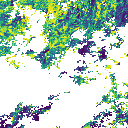
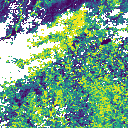
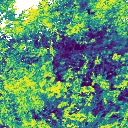
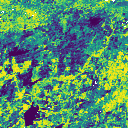
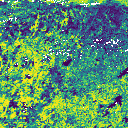

In [7]:
from pyrasterframes.rasterfunctions import *
from pyspark.sql.functions import lit

# Read a MODIS surface reflectance granule
df = spark.read.raster('https://modis-pds.s3.amazonaws.com/MCD43A4.006/11/08/2019059/MCD43A4.A2019059.h11v08.006.2019072203257_B02.TIF')

# Add 3 element-wise, show some rows of the DataFrame
sample = df.withColumn('added', rf_local_add(df.proj_raster, lit(3))) \
  .select(rf_crs('added'), rf_extent('added'), rf_tile('added'))
sample

In [9]:
scene1_B01 = "https://modis-pds.s3.amazonaws.com/MCD43A4.006/04/09/2018185/MCD43A4.A2018185.h04v09.006.2018194032851_B01.TIF"
scene2_B01 = "https://modis-pds.s3.amazonaws.com/MCD43A4.006/04/09/2018188/MCD43A4.A2018188.h04v09.006.2018198232008_B01.TIF"

import pandas as pd
from pyspark.sql import Row
# a pandas DF
one_d_cat_pd = pd.DataFrame({'B01': [scene1_B01, scene2_B01]})

# equivalent spark DF
one_d_cat_df = spark.createDataFrame([Row(B01=scene1_B01), Row(B01=scene2_B01)])

# equivalent CSV string
one_d_cat_csv = '\n'.join(['B01', scene1_B01, scene2_B01])

print (one_d_cat_csv)

B01
https://modis-pds.s3.amazonaws.com/MCD43A4.006/04/09/2018185/MCD43A4.A2018185.h04v09.006.2018194032851_B01.TIF
https://modis-pds.s3.amazonaws.com/MCD43A4.006/04/09/2018188/MCD43A4.A2018188.h04v09.006.2018198232008_B01.TIF


In [10]:
# Construct a CSV "catalog" for RasterFrames `raster` reader. Catalogs can also be Spark or Pandas DataFrames.
from pyspark.sql import Row
bands = [f'B{b}' for b in [4, 5]]
uris = [f'https://landsat-pds.s3.us-west-2.amazonaws.com/c1/L8/014/032/LC08_L1TP_014032_20190720_20190731_01_T1/LC08_L1TP_014032_20190720_20190731_01_T1_{b}.TIF' for b in bands]
catalog = ','.join(bands) + '\n' + ','.join(uris)

# Read red and NIR bands from Landsat 8 dataset over NYC
rf = spark.read.raster(catalog, bands) \
    .withColumnRenamed('B4', 'red').withColumnRenamed('B5', 'NIR') \
    .withColumn('longitude_latitude', st_reproject(st_centroid(rf_geometry('red')), rf_crs('red'), lit('EPSG:4326'))) \
    .withColumn('NDVI', rf_normalized_difference('NIR', 'red')) \
    .where(rf_tile_sum('NDVI') > 10000)

In [11]:
from pyspark import SparkFiles
admin1_us_url = 'https://raw.githubusercontent.com/datasets/geo-admin1-us/master/data/admin1-us.geojson'
spark.sparkContext.addFile(admin1_us_url)  # this lets us read http scheme uri's in spark

df = spark.read.geojson(SparkFiles.get('admin1-us.geojson'))
df.printSchema()

root
 |-- geometry: geometry (nullable = true)
 |-- ISO3166-1-Alpha-3: string (nullable = true)
 |-- country: string (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- state_code: string (nullable = true)



In [12]:
from pyspark.sql import Row
uri_pattern = 'https://s22s-test-geotiffs.s3.amazonaws.com/luray_snp/B0{}.tif'
catalog_df = spark.createDataFrame([
    Row(red=uri_pattern.format(4), nir=uri_pattern.format(8))
])
df = spark.read.raster(
    catalog_df,
    catalog_col_names=['red', 'nir']
)
df.printSchema()

root
 |-- red_path: string (nullable = false)
 |-- nir_path: string (nullable = false)
 |-- red: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nullable = false)
 |    |-- tile: tile (nullable = false)
 |-- nir: struct (nullable = true)
 |    |-- tile_context: struct (nullable = true)
 |    |    |-- extent: struct (nullable = false)
 |    |    |    |-- xmin: double (nullable = false)
 |    |    |    |-- ymin: double (nullable = false)
 |    |    |    |-- xmax: double (nullable = false)
 |    |    |    |-- ymax: double (nullable = false)
 |    |    |-- crs: struct (nullable = false)
 |    |    |    |-- crsProj4: string (nulla

In [13]:
# Use the provided convenience function to create a basic local SparkContext
spark = create_rf_spark_session()

# Construct a CSV "catalog" for RasterFrames `raster` reader. Catalogs can also be Spark or Pandas DataFrames.
bands = [f'B{b}' for b in [4, 5]]
uris = [f'https://landsat-pds.s3.us-west-2.amazonaws.com/c1/L8/014/032/LC08_L1TP_014032_20190720_20190731_01_T1/LC08_L1TP_014032_20190720_20190731_01_T1_{b}.TIF' for b in bands]
catalog = ','.join(bands) + '\n' + ','.join(uris)

# Read red and NIR bands from Landsat 8 dataset over NYC
rf = spark.read.raster(catalog, bands) \
    .withColumnRenamed('B4', 'red').withColumnRenamed('B5', 'NIR') \
    .withColumn('longitude_latitude', st_reproject(st_centroid(rf_geometry('red')), rf_crs('red'), lit('EPSG:4326'))) \
    .withColumn('NDVI', rf_normalized_difference('NIR', 'red')) \
    .where(rf_tile_sum('NDVI') > 10000)

longitude_latitude,rf_tile(red),rf_tile(NIR),rf_tile(NDVI)
POINT (-75.64310549921628 41.35507991091...,,,
POINT (-75.55129747458508 41.35555632722...,,,
POINT (-75.64242580157753 41.28590485893...,,,
POINT (-75.55071479581207 41.28638012434...,,,
POINT (-75.45900176161878 41.28678233172...,,,

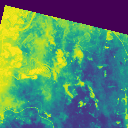
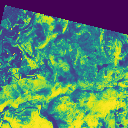
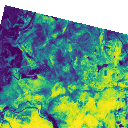
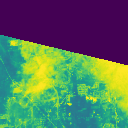
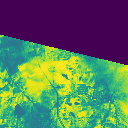
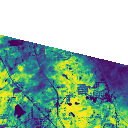
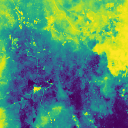
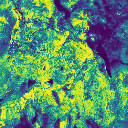
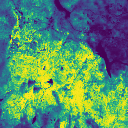
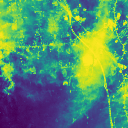
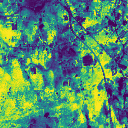
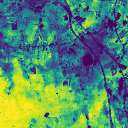
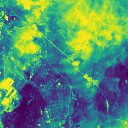
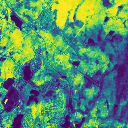
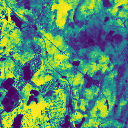

In [14]:
results = rf.select('longitude_latitude', rf_tile('red'), rf_tile('NIR'), rf_tile('NDVI'))
#displayHTML(rf_ipython.spark_df_to_html(results))
results